# ft_sommelier
### *Elementary Machine Learning Project*
![img](https://www.42.us.org/wp-content/uploads/2017/07/logo.png)

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy

%matplotlib inline

In [2]:
try:
    wine_data = pd.read_csv('winequality-red copy.csv', sep=';')
except FileNotFoundError:
    print('[-] Choose the correct dataset')


In [3]:
#Exploring the data
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# V.1  Exploring the green reds

**a)** Write a **function** that will **plot** a **scatterplot matrix** of your red wine data. 

In [4]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    # 1.Load the variables from the data
    num_vars, num_data = wine_data.shape
    # 2.Assign the names of colomns in a dataset to labels in a matrix
    label = wine_data.columns
    # 3.Create the subplot of the size of the Series
    sub, axes = plt.subplots(nrows=num_data, ncols=num_data, figsize=(35, 35))
    # 4. Remove the x and y axis to get a results as in a PDF
    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    # Remove the spaces
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    #Place labels as the diagnonal line
    for i, j in enumerate(label):
        axes[i,i].annotate(j, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
    # Take only in good_quality the columns where quality is greater than the good_threshold (which is 6)
    good_quality = wine_data[(wine_data['quality'] > good_threshold)]
    # Same for bad quality (5 and lower)
    bad_quality = wine_data[(wine_data['quality'] < bad_threshold)]
    # Fill the subplots with the data
    for i in range(num_data):
        for j in range(i + 1, num_data):
            # Wite twice in order not to overwrite
            axes[i, j].scatter(good_quality.iloc[:, j], good_quality.iloc[:, i], c=['goldenrod'], marker='.')
            axes[i, j].scatter(bad_quality.iloc[:, j], bad_quality.iloc[:, i], c =['mediumslateblue'], marker='.')
            axes[j, i].scatter(good_quality.iloc[:, i], good_quality.iloc[:, j], c =['goldenrod'], marker='.')
            axes[j, i].scatter(bad_quality.iloc[:, i], bad_quality.iloc[:, j], c = ['mediumslateblue'], marker='.')
    plt.show()

A simple sctterplox matrix of our red wine data



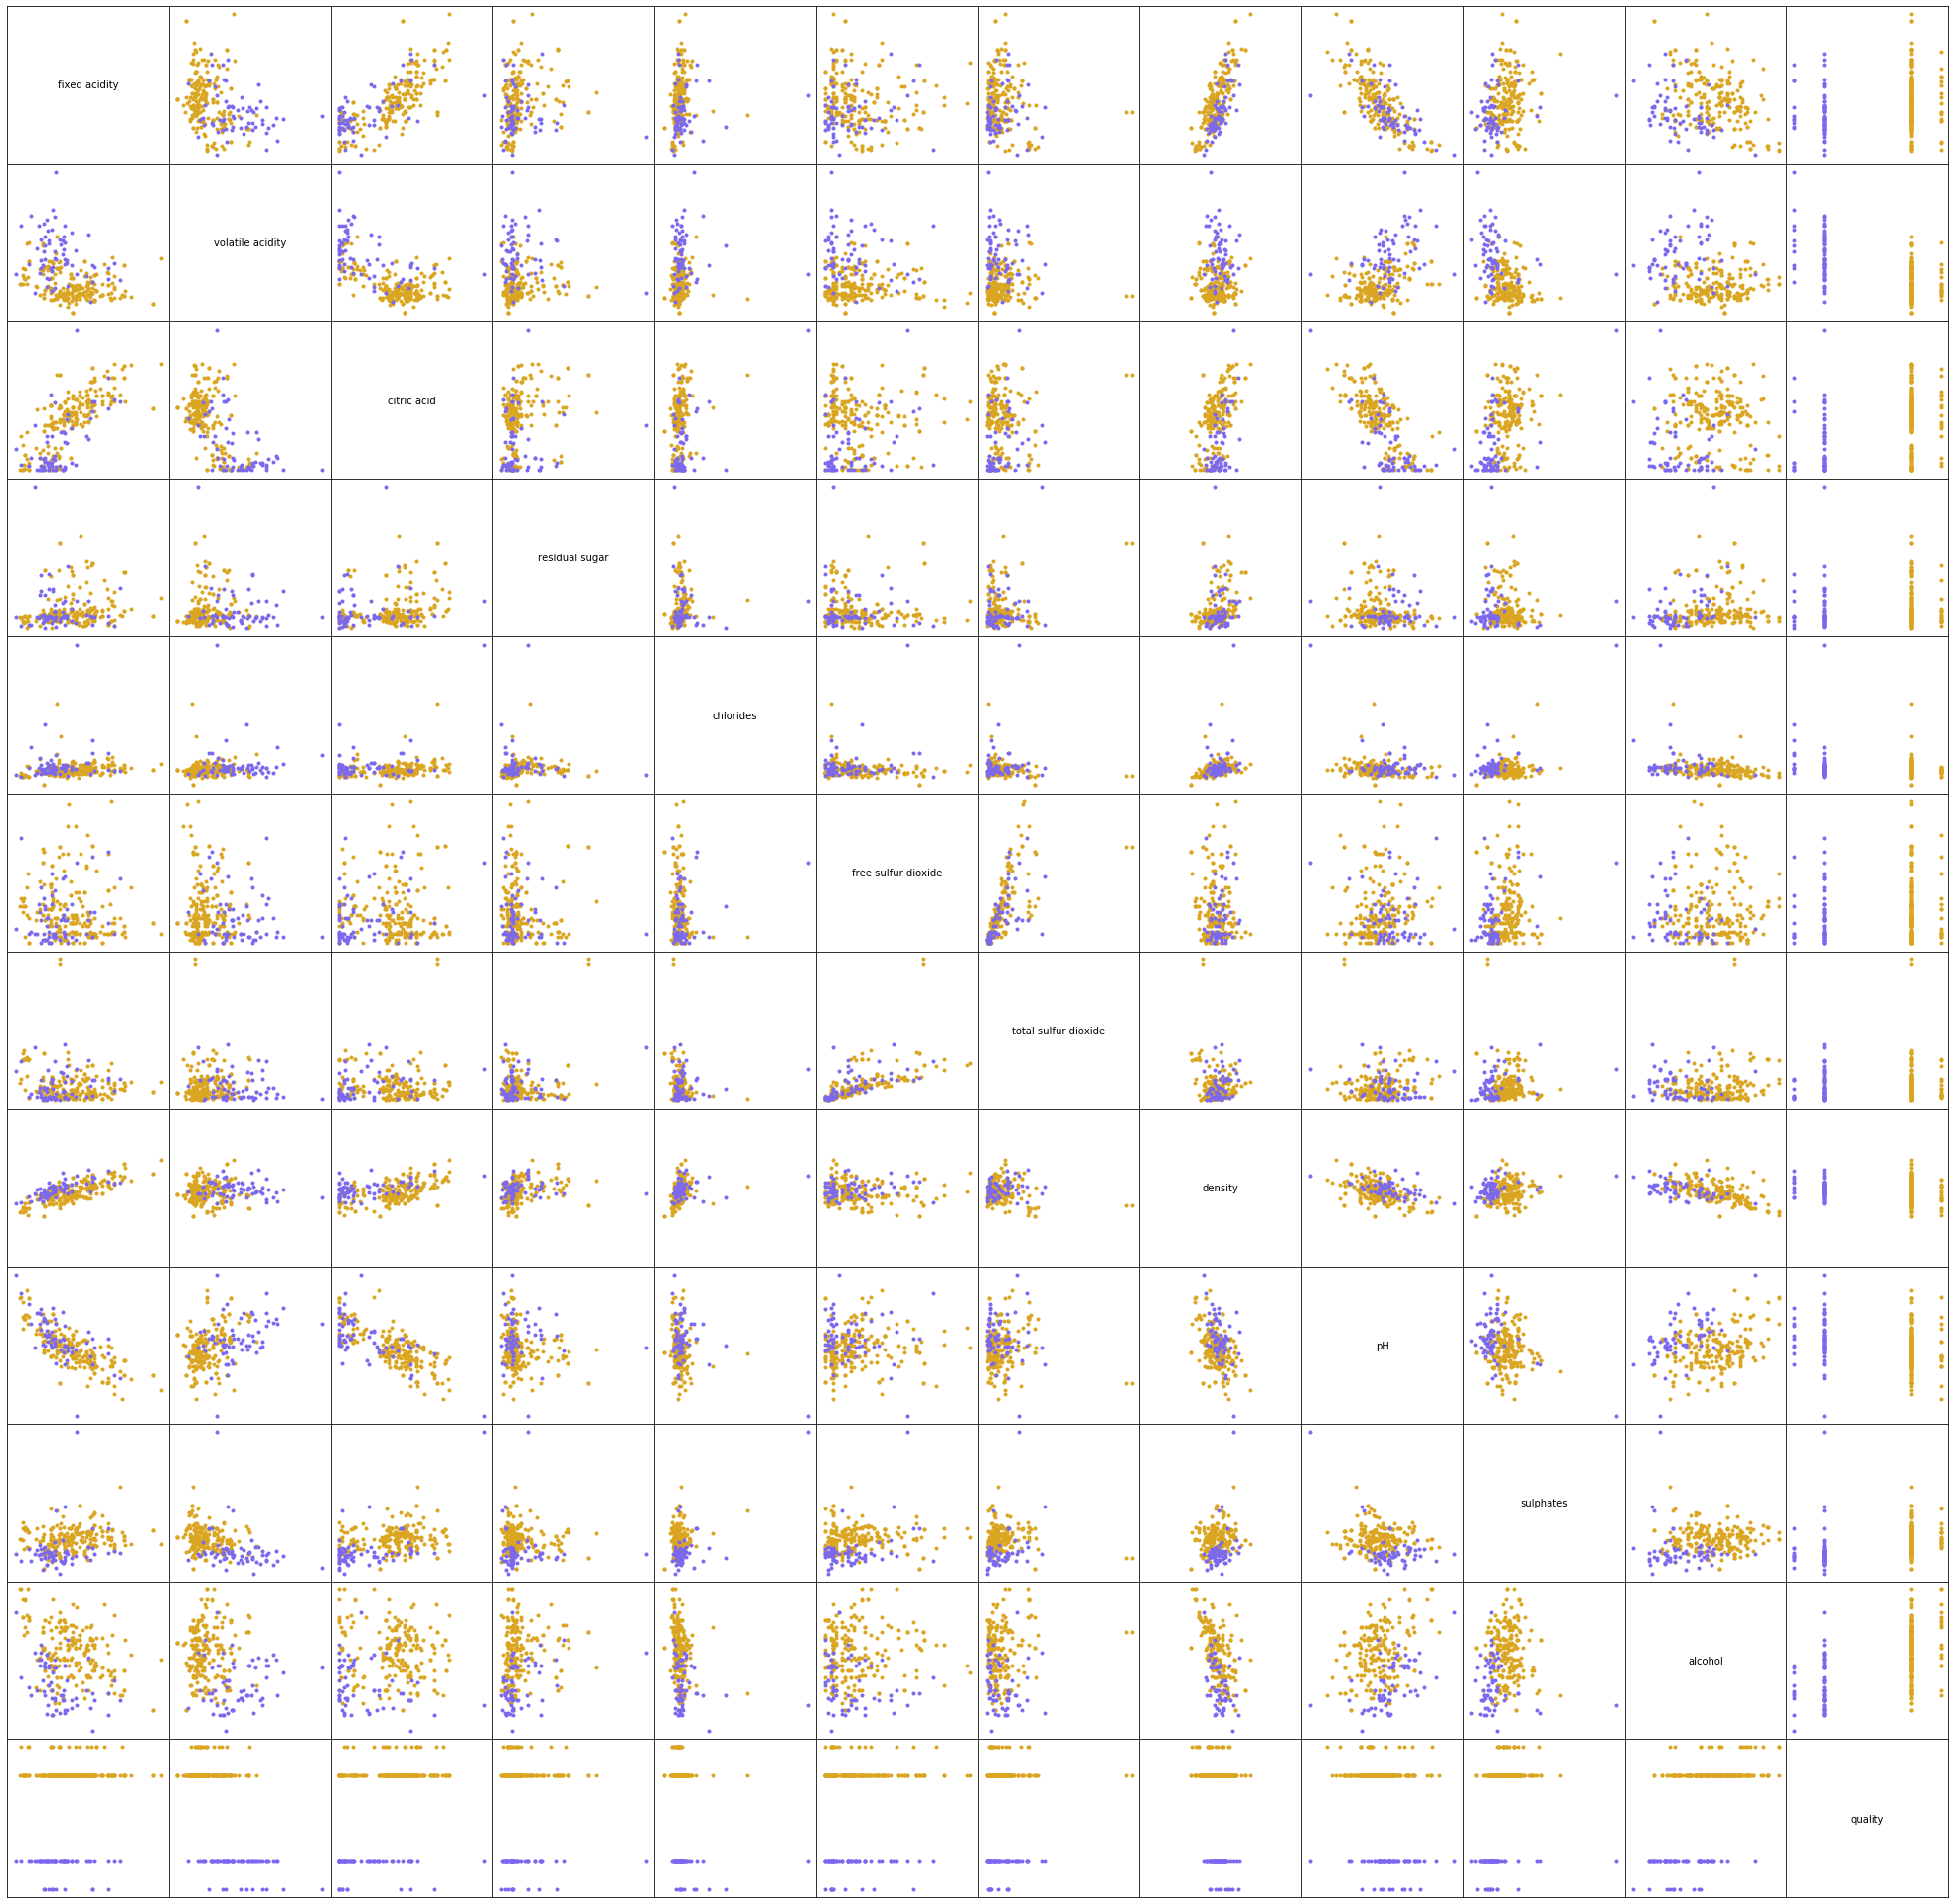

In [5]:
print('A simple sctterplox matrix of our red wine data\n')
plot_scatter_matrix(wine_data, 6, 5, True)


**b)** Which factors will be more useful for distingushing high quality vs. low quality wines?

Judging from the data, **alcohol** and **sulphates** are two of the most useful 
factors when it comes to distinguishing between high quality vs. low quality red wines.If you 
look at the picture, there is a strong correlation and big difference between yellow dots 
and blue dots(good wines and bad wines accordingly).

# V.2 Learning to perceptron

**a)** Implement a perceptron that:
* Has randomly initialized weights and bias
* Uses the Rosenblatt perceptron learning rule
* Utilizes the heavyside step activation function 

**b)** Implement a function to train your perceptron
* Specify the number of training epochs
* Train until it makes no errors
* Specify a learning rate
* Return performance
    
_Perceptron Model_
    
![img_2](https://cdn-images-1.medium.com/max/800/1*LyDp1dru7psq3044D2AXsQ.png)

In [6]:
wine_data = wine_data.assign(goodness=pd.Series(wine_data['quality'] >= 6))

selected_data = wine_data[(wine_data['quality'] >= 8) | (wine_data['quality'] <= 3)][['pH', 'alcohol', 'quality', 'goodness']]
selected_data = selected_data.reset_index(drop=True)

print('We selected {} samples and 2 chemicals factors\n'.format(selected_data.shape[0]))
print(selected_data)

We selected 28 samples and 2 chemicals factors

      pH  alcohol  quality  goodness
0   3.35    12.80        8      True
1   3.23    12.60        8      True
2   3.56    12.90        8      True
3   2.88     9.80        8      True
4   3.22    13.40        8      True
5   3.25     9.00        3     False
6   3.15    11.70        8      True
7   3.15    11.00        8      True
8   3.15    11.00        8      True
9   3.16     8.40        3     False
10  3.72    14.00        8      True
11  3.63    10.70        3     False
12  3.46    12.70        8      True
13  3.38     9.90        3     False
14  3.48    11.00        3     False
15  3.21    12.50        8      True
16  2.98    11.80        8      True
17  3.20    13.10        8      True
18  3.35    11.70        8      True
19  3.50    14.00        8      True
20  3.50    10.90        3     False
21  3.32     9.80        3     False
22  3.23    10.00        8      True
23  3.23    11.30        8      True
24  3.31     9.70        3 

In [29]:
class Perceptron:
    
    def __init__(self, lr):
        self.W = random.random()
        self.lr = lr
        self.performance = list()
    
    #Checking inputs so they are of equal lenght. Error otherwise 
    def _net_input(self, X):
        if len(self.W[1:]) != len(X):
            raise ValueError('Sorry but arguments have different length')
        result = 0
        for i in range(len(self.W[1:])):
            result += self.W[1:][i] * X[i]
        return result + self.W[0]
    
    #Using the heaviside step function:
    def predict(self, X):
        return 1 if self._net_input(X) > 0.0 else 0
    
    def evaluate_accuracy(self, X, y):
        num_correct = 0

        for xi, yi in zip(X, y):
            num_correct += int(self.predict(xi) == int(yi))
        
        accuracy = num_correct / len(y)
        return accuracy
    
    def _train_epoch(self, X, y, epoch):
        epoch_errors = 0

        for xi, yi in zip(X, y):
            update = self.lr * (yi - self.predict(xi))
            self.W[0] += update
            self.W[1:] += update * xi
            epoch_errors += int(update != 0.0)

        print('Epoch {}, {} errors'.format(epoch, epoch_errors))
        self.performance.append((epoch, epoch_errors, self.W[1:], self.W[0]))
        
        return epoch_errors
    
    def train(self, X, y, epochs):
        if epochs < 0:
            raise ValueError('An invalid number of training epochs')
        # if self.W is None:
        self.W = [0.0001 * random.uniform(-1, 1) for i in range(X.shape[1] + 1)]

        epoch = 0
        while True:
            epoch_errors = self._train_epoch(X, y, epoch)
            epoch += 1
            if epochs != 0 and epoch == epochs:
                break
            elif epochs == 0 and epoch_errors == 0:
                break
        
        return self.performance

In [30]:
X = selected_data.loc[:, ['pH', 'alcohol']]
Y = selected_data['goodness'].values

#Learning rate is the lenght of steps the alg makes down the gradient on the error curve

p = Perceptron(lr=0.008)
train_process = p.train(X.values, Y, 14000)

Epoch 0, 13 errors
Epoch 1, 13 errors
Epoch 2, 11 errors
Epoch 3, 11 errors
Epoch 4, 11 errors
Epoch 5, 13 errors
Epoch 6, 11 errors
Epoch 7, 13 errors
Epoch 8, 7 errors
Epoch 9, 2 errors
Epoch 10, 6 errors
Epoch 11, 9 errors
Epoch 12, 2 errors
Epoch 13, 2 errors
Epoch 14, 2 errors
Epoch 15, 4 errors
Epoch 16, 6 errors
Epoch 17, 7 errors
Epoch 18, 4 errors
Epoch 19, 2 errors
Epoch 20, 4 errors
Epoch 21, 6 errors
Epoch 22, 7 errors
Epoch 23, 4 errors
Epoch 24, 2 errors
Epoch 25, 4 errors
Epoch 26, 6 errors
Epoch 27, 8 errors
Epoch 28, 9 errors
Epoch 29, 8 errors
Epoch 30, 5 errors
Epoch 31, 4 errors
Epoch 32, 4 errors
Epoch 33, 6 errors
Epoch 34, 8 errors
Epoch 35, 7 errors
Epoch 36, 4 errors
Epoch 37, 6 errors
Epoch 38, 8 errors
Epoch 39, 7 errors
Epoch 40, 4 errors
Epoch 41, 6 errors
Epoch 42, 8 errors
Epoch 43, 3 errors
Epoch 44, 4 errors
Epoch 45, 2 errors
Epoch 46, 2 errors
Epoch 47, 2 errors
Epoch 48, 2 errors
Epoch 49, 4 errors
Epoch 50, 4 errors
Epoch 51, 6 errors
Epoch 52, 8 er

Epoch 633, 2 errors
Epoch 634, 4 errors
Epoch 635, 2 errors
Epoch 636, 4 errors
Epoch 637, 2 errors
Epoch 638, 4 errors
Epoch 639, 4 errors
Epoch 640, 4 errors
Epoch 641, 4 errors
Epoch 642, 2 errors
Epoch 643, 4 errors
Epoch 644, 2 errors
Epoch 645, 4 errors
Epoch 646, 4 errors
Epoch 647, 4 errors
Epoch 648, 4 errors
Epoch 649, 2 errors
Epoch 650, 4 errors
Epoch 651, 2 errors
Epoch 652, 4 errors
Epoch 653, 4 errors
Epoch 654, 4 errors
Epoch 655, 4 errors
Epoch 656, 2 errors
Epoch 657, 4 errors
Epoch 658, 2 errors
Epoch 659, 4 errors
Epoch 660, 2 errors
Epoch 661, 4 errors
Epoch 662, 4 errors
Epoch 663, 4 errors
Epoch 664, 2 errors
Epoch 665, 4 errors
Epoch 666, 2 errors
Epoch 667, 4 errors
Epoch 668, 2 errors
Epoch 669, 4 errors
Epoch 670, 2 errors
Epoch 671, 4 errors
Epoch 672, 2 errors
Epoch 673, 4 errors
Epoch 674, 4 errors
Epoch 675, 4 errors
Epoch 676, 2 errors
Epoch 677, 4 errors
Epoch 678, 2 errors
Epoch 679, 4 errors
Epoch 680, 2 errors
Epoch 681, 4 errors
Epoch 682, 2 errors


Epoch 1223, 2 errors
Epoch 1224, 2 errors
Epoch 1225, 2 errors
Epoch 1226, 2 errors
Epoch 1227, 2 errors
Epoch 1228, 2 errors
Epoch 1229, 2 errors
Epoch 1230, 2 errors
Epoch 1231, 2 errors
Epoch 1232, 2 errors
Epoch 1233, 2 errors
Epoch 1234, 2 errors
Epoch 1235, 2 errors
Epoch 1236, 2 errors
Epoch 1237, 2 errors
Epoch 1238, 2 errors
Epoch 1239, 2 errors
Epoch 1240, 1 errors
Epoch 1241, 2 errors
Epoch 1242, 2 errors
Epoch 1243, 2 errors
Epoch 1244, 2 errors
Epoch 1245, 2 errors
Epoch 1246, 2 errors
Epoch 1247, 2 errors
Epoch 1248, 2 errors
Epoch 1249, 2 errors
Epoch 1250, 2 errors
Epoch 1251, 2 errors
Epoch 1252, 2 errors
Epoch 1253, 2 errors
Epoch 1254, 2 errors
Epoch 1255, 2 errors
Epoch 1256, 2 errors
Epoch 1257, 2 errors
Epoch 1258, 2 errors
Epoch 1259, 2 errors
Epoch 1260, 2 errors
Epoch 1261, 2 errors
Epoch 1262, 2 errors
Epoch 1263, 1 errors
Epoch 1264, 2 errors
Epoch 1265, 2 errors
Epoch 1266, 2 errors
Epoch 1267, 2 errors
Epoch 1268, 2 errors
Epoch 1269, 2 errors
Epoch 1270, 2

Epoch 1852, 2 errors
Epoch 1853, 2 errors
Epoch 1854, 2 errors
Epoch 1855, 2 errors
Epoch 1856, 2 errors
Epoch 1857, 2 errors
Epoch 1858, 2 errors
Epoch 1859, 2 errors
Epoch 1860, 2 errors
Epoch 1861, 2 errors
Epoch 1862, 1 errors
Epoch 1863, 2 errors
Epoch 1864, 2 errors
Epoch 1865, 2 errors
Epoch 1866, 2 errors
Epoch 1867, 2 errors
Epoch 1868, 2 errors
Epoch 1869, 2 errors
Epoch 1870, 2 errors
Epoch 1871, 2 errors
Epoch 1872, 2 errors
Epoch 1873, 2 errors
Epoch 1874, 2 errors
Epoch 1875, 2 errors
Epoch 1876, 2 errors
Epoch 1877, 2 errors
Epoch 1878, 2 errors
Epoch 1879, 2 errors
Epoch 1880, 2 errors
Epoch 1881, 2 errors
Epoch 1882, 2 errors
Epoch 1883, 2 errors
Epoch 1884, 1 errors
Epoch 1885, 2 errors
Epoch 1886, 2 errors
Epoch 1887, 2 errors
Epoch 1888, 2 errors
Epoch 1889, 2 errors
Epoch 1890, 2 errors
Epoch 1891, 2 errors
Epoch 1892, 2 errors
Epoch 1893, 2 errors
Epoch 1894, 2 errors
Epoch 1895, 2 errors
Epoch 1896, 2 errors
Epoch 1897, 2 errors
Epoch 1898, 2 errors
Epoch 1899, 2

Epoch 2561, 2 errors
Epoch 2562, 2 errors
Epoch 2563, 2 errors
Epoch 2564, 2 errors
Epoch 2565, 2 errors
Epoch 2566, 2 errors
Epoch 2567, 2 errors
Epoch 2568, 2 errors
Epoch 2569, 2 errors
Epoch 2570, 2 errors
Epoch 2571, 2 errors
Epoch 2572, 2 errors
Epoch 2573, 2 errors
Epoch 2574, 2 errors
Epoch 2575, 2 errors
Epoch 2576, 2 errors
Epoch 2577, 2 errors
Epoch 2578, 2 errors
Epoch 2579, 2 errors
Epoch 2580, 2 errors
Epoch 2581, 1 errors
Epoch 2582, 2 errors
Epoch 2583, 2 errors
Epoch 2584, 2 errors
Epoch 2585, 2 errors
Epoch 2586, 2 errors
Epoch 2587, 2 errors
Epoch 2588, 2 errors
Epoch 2589, 2 errors
Epoch 2590, 2 errors
Epoch 2591, 2 errors
Epoch 2592, 2 errors
Epoch 2593, 2 errors
Epoch 2594, 2 errors
Epoch 2595, 2 errors
Epoch 2596, 2 errors
Epoch 2597, 2 errors
Epoch 2598, 2 errors
Epoch 2599, 2 errors
Epoch 2600, 2 errors
Epoch 2601, 2 errors
Epoch 2602, 2 errors
Epoch 2603, 1 errors
Epoch 2604, 2 errors
Epoch 2605, 2 errors
Epoch 2606, 2 errors
Epoch 2607, 2 errors
Epoch 2608, 2

Epoch 3203, 2 errors
Epoch 3204, 2 errors
Epoch 3205, 2 errors
Epoch 3206, 2 errors
Epoch 3207, 2 errors
Epoch 3208, 2 errors
Epoch 3209, 2 errors
Epoch 3210, 2 errors
Epoch 3211, 1 errors
Epoch 3212, 2 errors
Epoch 3213, 2 errors
Epoch 3214, 2 errors
Epoch 3215, 2 errors
Epoch 3216, 2 errors
Epoch 3217, 2 errors
Epoch 3218, 2 errors
Epoch 3219, 2 errors
Epoch 3220, 2 errors
Epoch 3221, 2 errors
Epoch 3222, 2 errors
Epoch 3223, 2 errors
Epoch 3224, 2 errors
Epoch 3225, 2 errors
Epoch 3226, 2 errors
Epoch 3227, 2 errors
Epoch 3228, 2 errors
Epoch 3229, 2 errors
Epoch 3230, 1 errors
Epoch 3231, 2 errors
Epoch 3232, 2 errors
Epoch 3233, 2 errors
Epoch 3234, 2 errors
Epoch 3235, 2 errors
Epoch 3236, 2 errors
Epoch 3237, 2 errors
Epoch 3238, 2 errors
Epoch 3239, 2 errors
Epoch 3240, 2 errors
Epoch 3241, 2 errors
Epoch 3242, 2 errors
Epoch 3243, 2 errors
Epoch 3244, 2 errors
Epoch 3245, 2 errors
Epoch 3246, 2 errors
Epoch 3247, 2 errors
Epoch 3248, 2 errors
Epoch 3249, 1 errors
Epoch 3250, 2

Epoch 3859, 2 errors
Epoch 3860, 2 errors
Epoch 3861, 2 errors
Epoch 3862, 2 errors
Epoch 3863, 2 errors
Epoch 3864, 2 errors
Epoch 3865, 2 errors
Epoch 3866, 2 errors
Epoch 3867, 2 errors
Epoch 3868, 2 errors
Epoch 3869, 1 errors
Epoch 3870, 2 errors
Epoch 3871, 2 errors
Epoch 3872, 2 errors
Epoch 3873, 2 errors
Epoch 3874, 2 errors
Epoch 3875, 2 errors
Epoch 3876, 2 errors
Epoch 3877, 2 errors
Epoch 3878, 2 errors
Epoch 3879, 2 errors
Epoch 3880, 2 errors
Epoch 3881, 2 errors
Epoch 3882, 2 errors
Epoch 3883, 2 errors
Epoch 3884, 2 errors
Epoch 3885, 2 errors
Epoch 3886, 2 errors
Epoch 3887, 1 errors
Epoch 3888, 2 errors
Epoch 3889, 2 errors
Epoch 3890, 2 errors
Epoch 3891, 2 errors
Epoch 3892, 2 errors
Epoch 3893, 2 errors
Epoch 3894, 2 errors
Epoch 3895, 2 errors
Epoch 3896, 2 errors
Epoch 3897, 2 errors
Epoch 3898, 2 errors
Epoch 3899, 2 errors
Epoch 3900, 2 errors
Epoch 3901, 2 errors
Epoch 3902, 2 errors
Epoch 3903, 2 errors
Epoch 3904, 2 errors
Epoch 3905, 2 errors
Epoch 3906, 1

Epoch 4501, 2 errors
Epoch 4502, 2 errors
Epoch 4503, 2 errors
Epoch 4504, 2 errors
Epoch 4505, 2 errors
Epoch 4506, 2 errors
Epoch 4507, 1 errors
Epoch 4508, 2 errors
Epoch 4509, 2 errors
Epoch 4510, 2 errors
Epoch 4511, 2 errors
Epoch 4512, 2 errors
Epoch 4513, 2 errors
Epoch 4514, 2 errors
Epoch 4515, 2 errors
Epoch 4516, 2 errors
Epoch 4517, 2 errors
Epoch 4518, 2 errors
Epoch 4519, 2 errors
Epoch 4520, 2 errors
Epoch 4521, 2 errors
Epoch 4522, 2 errors
Epoch 4523, 2 errors
Epoch 4524, 2 errors
Epoch 4525, 2 errors
Epoch 4526, 1 errors
Epoch 4527, 2 errors
Epoch 4528, 2 errors
Epoch 4529, 2 errors
Epoch 4530, 2 errors
Epoch 4531, 2 errors
Epoch 4532, 2 errors
Epoch 4533, 2 errors
Epoch 4534, 2 errors
Epoch 4535, 2 errors
Epoch 4536, 2 errors
Epoch 4537, 2 errors
Epoch 4538, 2 errors
Epoch 4539, 2 errors
Epoch 4540, 2 errors
Epoch 4541, 2 errors
Epoch 4542, 2 errors
Epoch 4543, 2 errors
Epoch 4544, 1 errors
Epoch 4545, 2 errors
Epoch 4546, 2 errors
Epoch 4547, 2 errors
Epoch 4548, 2

Epoch 5104, 2 errors
Epoch 5105, 2 errors
Epoch 5106, 2 errors
Epoch 5107, 1 errors
Epoch 5108, 2 errors
Epoch 5109, 2 errors
Epoch 5110, 2 errors
Epoch 5111, 2 errors
Epoch 5112, 2 errors
Epoch 5113, 2 errors
Epoch 5114, 2 errors
Epoch 5115, 2 errors
Epoch 5116, 2 errors
Epoch 5117, 2 errors
Epoch 5118, 2 errors
Epoch 5119, 2 errors
Epoch 5120, 2 errors
Epoch 5121, 2 errors
Epoch 5122, 2 errors
Epoch 5123, 2 errors
Epoch 5124, 2 errors
Epoch 5125, 2 errors
Epoch 5126, 1 errors
Epoch 5127, 2 errors
Epoch 5128, 2 errors
Epoch 5129, 2 errors
Epoch 5130, 2 errors
Epoch 5131, 2 errors
Epoch 5132, 2 errors
Epoch 5133, 2 errors
Epoch 5134, 2 errors
Epoch 5135, 2 errors
Epoch 5136, 2 errors
Epoch 5137, 2 errors
Epoch 5138, 2 errors
Epoch 5139, 2 errors
Epoch 5140, 2 errors
Epoch 5141, 2 errors
Epoch 5142, 2 errors
Epoch 5143, 2 errors
Epoch 5144, 2 errors
Epoch 5145, 1 errors
Epoch 5146, 2 errors
Epoch 5147, 2 errors
Epoch 5148, 2 errors
Epoch 5149, 2 errors
Epoch 5150, 2 errors
Epoch 5151, 2

Epoch 5739, 2 errors
Epoch 5740, 2 errors
Epoch 5741, 2 errors
Epoch 5742, 2 errors
Epoch 5743, 2 errors
Epoch 5744, 2 errors
Epoch 5745, 2 errors
Epoch 5746, 1 errors
Epoch 5747, 2 errors
Epoch 5748, 2 errors
Epoch 5749, 2 errors
Epoch 5750, 2 errors
Epoch 5751, 2 errors
Epoch 5752, 2 errors
Epoch 5753, 2 errors
Epoch 5754, 2 errors
Epoch 5755, 2 errors
Epoch 5756, 2 errors
Epoch 5757, 2 errors
Epoch 5758, 2 errors
Epoch 5759, 2 errors
Epoch 5760, 2 errors
Epoch 5761, 2 errors
Epoch 5762, 2 errors
Epoch 5763, 2 errors
Epoch 5764, 1 errors
Epoch 5765, 2 errors
Epoch 5766, 2 errors
Epoch 5767, 2 errors
Epoch 5768, 2 errors
Epoch 5769, 2 errors
Epoch 5770, 2 errors
Epoch 5771, 2 errors
Epoch 5772, 2 errors
Epoch 5773, 2 errors
Epoch 5774, 2 errors
Epoch 5775, 2 errors
Epoch 5776, 2 errors
Epoch 5777, 2 errors
Epoch 5778, 2 errors
Epoch 5779, 2 errors
Epoch 5780, 2 errors
Epoch 5781, 2 errors
Epoch 5782, 2 errors
Epoch 5783, 1 errors
Epoch 5784, 2 errors
Epoch 5785, 2 errors
Epoch 5786, 2

Epoch 6482, 2 errors
Epoch 6483, 2 errors
Epoch 6484, 2 errors
Epoch 6485, 2 errors
Epoch 6486, 2 errors
Epoch 6487, 2 errors
Epoch 6488, 2 errors
Epoch 6489, 2 errors
Epoch 6490, 2 errors
Epoch 6491, 2 errors
Epoch 6492, 2 errors
Epoch 6493, 2 errors
Epoch 6494, 2 errors
Epoch 6495, 2 errors
Epoch 6496, 2 errors
Epoch 6497, 1 errors
Epoch 6498, 2 errors
Epoch 6499, 2 errors
Epoch 6500, 2 errors
Epoch 6501, 2 errors
Epoch 6502, 2 errors
Epoch 6503, 2 errors
Epoch 6504, 2 errors
Epoch 6505, 2 errors
Epoch 6506, 2 errors
Epoch 6507, 2 errors
Epoch 6508, 2 errors
Epoch 6509, 2 errors
Epoch 6510, 2 errors
Epoch 6511, 2 errors
Epoch 6512, 2 errors
Epoch 6513, 2 errors
Epoch 6514, 2 errors
Epoch 6515, 1 errors
Epoch 6516, 2 errors
Epoch 6517, 2 errors
Epoch 6518, 2 errors
Epoch 6519, 2 errors
Epoch 6520, 2 errors
Epoch 6521, 2 errors
Epoch 6522, 2 errors
Epoch 6523, 2 errors
Epoch 6524, 2 errors
Epoch 6525, 2 errors
Epoch 6526, 2 errors
Epoch 6527, 2 errors
Epoch 6528, 2 errors
Epoch 6529, 2

Epoch 7101, 2 errors
Epoch 7102, 2 errors
Epoch 7103, 2 errors
Epoch 7104, 2 errors
Epoch 7105, 2 errors
Epoch 7106, 2 errors
Epoch 7107, 2 errors
Epoch 7108, 2 errors
Epoch 7109, 2 errors
Epoch 7110, 2 errors
Epoch 7111, 2 errors
Epoch 7112, 2 errors
Epoch 7113, 2 errors
Epoch 7114, 2 errors
Epoch 7115, 2 errors
Epoch 7116, 1 errors
Epoch 7117, 2 errors
Epoch 7118, 2 errors
Epoch 7119, 2 errors
Epoch 7120, 2 errors
Epoch 7121, 2 errors
Epoch 7122, 2 errors
Epoch 7123, 2 errors
Epoch 7124, 2 errors
Epoch 7125, 2 errors
Epoch 7126, 2 errors
Epoch 7127, 2 errors
Epoch 7128, 2 errors
Epoch 7129, 2 errors
Epoch 7130, 2 errors
Epoch 7131, 2 errors
Epoch 7132, 2 errors
Epoch 7133, 2 errors
Epoch 7134, 2 errors
Epoch 7135, 1 errors
Epoch 7136, 2 errors
Epoch 7137, 2 errors
Epoch 7138, 2 errors
Epoch 7139, 2 errors
Epoch 7140, 2 errors
Epoch 7141, 2 errors
Epoch 7142, 2 errors
Epoch 7143, 2 errors
Epoch 7144, 2 errors
Epoch 7145, 2 errors
Epoch 7146, 2 errors
Epoch 7147, 2 errors
Epoch 7148, 2

Epoch 7802, 2 errors
Epoch 7803, 2 errors
Epoch 7804, 2 errors
Epoch 7805, 2 errors
Epoch 7806, 2 errors
Epoch 7807, 2 errors
Epoch 7808, 2 errors
Epoch 7809, 2 errors
Epoch 7810, 2 errors
Epoch 7811, 1 errors
Epoch 7812, 2 errors
Epoch 7813, 2 errors
Epoch 7814, 2 errors
Epoch 7815, 2 errors
Epoch 7816, 2 errors
Epoch 7817, 2 errors
Epoch 7818, 2 errors
Epoch 7819, 2 errors
Epoch 7820, 2 errors
Epoch 7821, 2 errors
Epoch 7822, 2 errors
Epoch 7823, 2 errors
Epoch 7824, 2 errors
Epoch 7825, 2 errors
Epoch 7826, 2 errors
Epoch 7827, 2 errors
Epoch 7828, 2 errors
Epoch 7829, 1 errors
Epoch 7830, 2 errors
Epoch 7831, 2 errors
Epoch 7832, 2 errors
Epoch 7833, 2 errors
Epoch 7834, 2 errors
Epoch 7835, 2 errors
Epoch 7836, 2 errors
Epoch 7837, 2 errors
Epoch 7838, 2 errors
Epoch 7839, 2 errors
Epoch 7840, 2 errors
Epoch 7841, 2 errors
Epoch 7842, 2 errors
Epoch 7843, 2 errors
Epoch 7844, 2 errors
Epoch 7845, 2 errors
Epoch 7846, 2 errors
Epoch 7847, 2 errors
Epoch 7848, 1 errors
Epoch 7849, 2

Epoch 8505, 1 errors
Epoch 8506, 2 errors
Epoch 8507, 2 errors
Epoch 8508, 2 errors
Epoch 8509, 2 errors
Epoch 8510, 2 errors
Epoch 8511, 2 errors
Epoch 8512, 2 errors
Epoch 8513, 2 errors
Epoch 8514, 2 errors
Epoch 8515, 2 errors
Epoch 8516, 2 errors
Epoch 8517, 2 errors
Epoch 8518, 2 errors
Epoch 8519, 2 errors
Epoch 8520, 2 errors
Epoch 8521, 2 errors
Epoch 8522, 2 errors
Epoch 8523, 2 errors
Epoch 8524, 1 errors
Epoch 8525, 2 errors
Epoch 8526, 2 errors
Epoch 8527, 2 errors
Epoch 8528, 2 errors
Epoch 8529, 2 errors
Epoch 8530, 2 errors
Epoch 8531, 2 errors
Epoch 8532, 2 errors
Epoch 8533, 2 errors
Epoch 8534, 2 errors
Epoch 8535, 2 errors
Epoch 8536, 2 errors
Epoch 8537, 2 errors
Epoch 8538, 2 errors
Epoch 8539, 2 errors
Epoch 8540, 2 errors
Epoch 8541, 2 errors
Epoch 8542, 2 errors
Epoch 8543, 1 errors
Epoch 8544, 2 errors
Epoch 8545, 2 errors
Epoch 8546, 2 errors
Epoch 8547, 2 errors
Epoch 8548, 2 errors
Epoch 8549, 2 errors
Epoch 8550, 2 errors
Epoch 8551, 2 errors
Epoch 8552, 2

Epoch 8955, 2 errors
Epoch 8956, 1 errors
Epoch 8957, 2 errors
Epoch 8958, 2 errors
Epoch 8959, 2 errors
Epoch 8960, 2 errors
Epoch 8961, 2 errors
Epoch 8962, 2 errors
Epoch 8963, 2 errors
Epoch 8964, 2 errors
Epoch 8965, 2 errors
Epoch 8966, 2 errors
Epoch 8967, 2 errors
Epoch 8968, 2 errors
Epoch 8969, 2 errors
Epoch 8970, 2 errors
Epoch 8971, 2 errors
Epoch 8972, 2 errors
Epoch 8973, 2 errors
Epoch 8974, 1 errors
Epoch 8975, 2 errors
Epoch 8976, 2 errors
Epoch 8977, 2 errors
Epoch 8978, 2 errors
Epoch 8979, 2 errors
Epoch 8980, 2 errors
Epoch 8981, 2 errors
Epoch 8982, 2 errors
Epoch 8983, 2 errors
Epoch 8984, 2 errors
Epoch 8985, 2 errors
Epoch 8986, 2 errors
Epoch 8987, 2 errors
Epoch 8988, 2 errors
Epoch 8989, 2 errors
Epoch 8990, 2 errors
Epoch 8991, 2 errors
Epoch 8992, 2 errors
Epoch 8993, 1 errors
Epoch 8994, 2 errors
Epoch 8995, 2 errors
Epoch 8996, 2 errors
Epoch 8997, 2 errors
Epoch 8998, 2 errors
Epoch 8999, 2 errors
Epoch 9000, 2 errors
Epoch 9001, 2 errors
Epoch 9002, 2

Epoch 9427, 2 errors
Epoch 9428, 2 errors
Epoch 9429, 2 errors
Epoch 9430, 2 errors
Epoch 9431, 2 errors
Epoch 9432, 2 errors
Epoch 9433, 2 errors
Epoch 9434, 2 errors
Epoch 9435, 2 errors
Epoch 9436, 2 errors
Epoch 9437, 2 errors
Epoch 9438, 2 errors
Epoch 9439, 2 errors
Epoch 9440, 2 errors
Epoch 9441, 2 errors
Epoch 9442, 2 errors
Epoch 9443, 2 errors
Epoch 9444, 1 errors
Epoch 9445, 2 errors
Epoch 9446, 2 errors
Epoch 9447, 2 errors
Epoch 9448, 2 errors
Epoch 9449, 2 errors
Epoch 9450, 2 errors
Epoch 9451, 2 errors
Epoch 9452, 2 errors
Epoch 9453, 2 errors
Epoch 9454, 2 errors
Epoch 9455, 2 errors
Epoch 9456, 2 errors
Epoch 9457, 2 errors
Epoch 9458, 2 errors
Epoch 9459, 2 errors
Epoch 9460, 2 errors
Epoch 9461, 2 errors
Epoch 9462, 1 errors
Epoch 9463, 2 errors
Epoch 9464, 2 errors
Epoch 9465, 2 errors
Epoch 9466, 2 errors
Epoch 9467, 2 errors
Epoch 9468, 2 errors
Epoch 9469, 2 errors
Epoch 9470, 2 errors
Epoch 9471, 2 errors
Epoch 9472, 2 errors
Epoch 9473, 2 errors
Epoch 9474, 2

Epoch 9931, 2 errors
Epoch 9932, 1 errors
Epoch 9933, 2 errors
Epoch 9934, 2 errors
Epoch 9935, 2 errors
Epoch 9936, 2 errors
Epoch 9937, 2 errors
Epoch 9938, 2 errors
Epoch 9939, 2 errors
Epoch 9940, 2 errors
Epoch 9941, 2 errors
Epoch 9942, 2 errors
Epoch 9943, 2 errors
Epoch 9944, 2 errors
Epoch 9945, 2 errors
Epoch 9946, 2 errors
Epoch 9947, 2 errors
Epoch 9948, 2 errors
Epoch 9949, 2 errors
Epoch 9950, 1 errors
Epoch 9951, 2 errors
Epoch 9952, 2 errors
Epoch 9953, 2 errors
Epoch 9954, 2 errors
Epoch 9955, 2 errors
Epoch 9956, 2 errors
Epoch 9957, 2 errors
Epoch 9958, 2 errors
Epoch 9959, 2 errors
Epoch 9960, 2 errors
Epoch 9961, 2 errors
Epoch 9962, 2 errors
Epoch 9963, 2 errors
Epoch 9964, 2 errors
Epoch 9965, 2 errors
Epoch 9966, 2 errors
Epoch 9967, 2 errors
Epoch 9968, 2 errors
Epoch 9969, 1 errors
Epoch 9970, 2 errors
Epoch 9971, 2 errors
Epoch 9972, 2 errors
Epoch 9973, 2 errors
Epoch 9974, 2 errors
Epoch 9975, 2 errors
Epoch 9976, 2 errors
Epoch 9977, 2 errors
Epoch 9978, 2

Epoch 10361, 2 errors
Epoch 10362, 2 errors
Epoch 10363, 1 errors
Epoch 10364, 2 errors
Epoch 10365, 2 errors
Epoch 10366, 2 errors
Epoch 10367, 2 errors
Epoch 10368, 2 errors
Epoch 10369, 2 errors
Epoch 10370, 2 errors
Epoch 10371, 2 errors
Epoch 10372, 2 errors
Epoch 10373, 2 errors
Epoch 10374, 2 errors
Epoch 10375, 2 errors
Epoch 10376, 2 errors
Epoch 10377, 2 errors
Epoch 10378, 2 errors
Epoch 10379, 2 errors
Epoch 10380, 2 errors
Epoch 10381, 2 errors
Epoch 10382, 1 errors
Epoch 10383, 2 errors
Epoch 10384, 2 errors
Epoch 10385, 2 errors
Epoch 10386, 2 errors
Epoch 10387, 2 errors
Epoch 10388, 2 errors
Epoch 10389, 2 errors
Epoch 10390, 2 errors
Epoch 10391, 2 errors
Epoch 10392, 2 errors
Epoch 10393, 2 errors
Epoch 10394, 2 errors
Epoch 10395, 2 errors
Epoch 10396, 2 errors
Epoch 10397, 2 errors
Epoch 10398, 2 errors
Epoch 10399, 2 errors
Epoch 10400, 2 errors
Epoch 10401, 1 errors
Epoch 10402, 2 errors
Epoch 10403, 2 errors
Epoch 10404, 2 errors
Epoch 10405, 2 errors
Epoch 1040

Epoch 11096, 1 errors
Epoch 11097, 2 errors
Epoch 11098, 2 errors
Epoch 11099, 2 errors
Epoch 11100, 2 errors
Epoch 11101, 2 errors
Epoch 11102, 2 errors
Epoch 11103, 2 errors
Epoch 11104, 2 errors
Epoch 11105, 2 errors
Epoch 11106, 2 errors
Epoch 11107, 2 errors
Epoch 11108, 2 errors
Epoch 11109, 2 errors
Epoch 11110, 2 errors
Epoch 11111, 2 errors
Epoch 11112, 2 errors
Epoch 11113, 2 errors
Epoch 11114, 1 errors
Epoch 11115, 2 errors
Epoch 11116, 2 errors
Epoch 11117, 2 errors
Epoch 11118, 2 errors
Epoch 11119, 2 errors
Epoch 11120, 2 errors
Epoch 11121, 2 errors
Epoch 11122, 2 errors
Epoch 11123, 2 errors
Epoch 11124, 2 errors
Epoch 11125, 2 errors
Epoch 11126, 2 errors
Epoch 11127, 2 errors
Epoch 11128, 2 errors
Epoch 11129, 2 errors
Epoch 11130, 2 errors
Epoch 11131, 2 errors
Epoch 11132, 2 errors
Epoch 11133, 1 errors
Epoch 11134, 2 errors
Epoch 11135, 2 errors
Epoch 11136, 2 errors
Epoch 11137, 2 errors
Epoch 11138, 2 errors
Epoch 11139, 2 errors
Epoch 11140, 2 errors
Epoch 1114

Epoch 11595, 2 errors
Epoch 11596, 2 errors
Epoch 11597, 2 errors
Epoch 11598, 2 errors
Epoch 11599, 2 errors
Epoch 11600, 2 errors
Epoch 11601, 2 errors
Epoch 11602, 1 errors
Epoch 11603, 2 errors
Epoch 11604, 2 errors
Epoch 11605, 2 errors
Epoch 11606, 2 errors
Epoch 11607, 2 errors
Epoch 11608, 2 errors
Epoch 11609, 2 errors
Epoch 11610, 2 errors
Epoch 11611, 2 errors
Epoch 11612, 2 errors
Epoch 11613, 2 errors
Epoch 11614, 2 errors
Epoch 11615, 2 errors
Epoch 11616, 2 errors
Epoch 11617, 2 errors
Epoch 11618, 2 errors
Epoch 11619, 2 errors
Epoch 11620, 2 errors
Epoch 11621, 1 errors
Epoch 11622, 2 errors
Epoch 11623, 2 errors
Epoch 11624, 2 errors
Epoch 11625, 2 errors
Epoch 11626, 2 errors
Epoch 11627, 2 errors
Epoch 11628, 2 errors
Epoch 11629, 2 errors
Epoch 11630, 2 errors
Epoch 11631, 2 errors
Epoch 11632, 2 errors
Epoch 11633, 2 errors
Epoch 11634, 2 errors
Epoch 11635, 2 errors
Epoch 11636, 2 errors
Epoch 11637, 2 errors
Epoch 11638, 2 errors
Epoch 11639, 2 errors
Epoch 1164

Epoch 12071, 2 errors
Epoch 12072, 1 errors
Epoch 12073, 2 errors
Epoch 12074, 2 errors
Epoch 12075, 2 errors
Epoch 12076, 2 errors
Epoch 12077, 2 errors
Epoch 12078, 2 errors
Epoch 12079, 2 errors
Epoch 12080, 2 errors
Epoch 12081, 2 errors
Epoch 12082, 2 errors
Epoch 12083, 2 errors
Epoch 12084, 2 errors
Epoch 12085, 2 errors
Epoch 12086, 2 errors
Epoch 12087, 2 errors
Epoch 12088, 2 errors
Epoch 12089, 2 errors
Epoch 12090, 1 errors
Epoch 12091, 2 errors
Epoch 12092, 2 errors
Epoch 12093, 2 errors
Epoch 12094, 2 errors
Epoch 12095, 2 errors
Epoch 12096, 2 errors
Epoch 12097, 2 errors
Epoch 12098, 2 errors
Epoch 12099, 2 errors
Epoch 12100, 2 errors
Epoch 12101, 2 errors
Epoch 12102, 2 errors
Epoch 12103, 2 errors
Epoch 12104, 2 errors
Epoch 12105, 2 errors
Epoch 12106, 2 errors
Epoch 12107, 2 errors
Epoch 12108, 2 errors
Epoch 12109, 1 errors
Epoch 12110, 2 errors
Epoch 12111, 2 errors
Epoch 12112, 2 errors
Epoch 12113, 2 errors
Epoch 12114, 2 errors
Epoch 12115, 2 errors
Epoch 1211

Epoch 12503, 1 errors
Epoch 12504, 2 errors
Epoch 12505, 2 errors
Epoch 12506, 2 errors
Epoch 12507, 2 errors
Epoch 12508, 2 errors
Epoch 12509, 2 errors
Epoch 12510, 2 errors
Epoch 12511, 2 errors
Epoch 12512, 2 errors
Epoch 12513, 2 errors
Epoch 12514, 2 errors
Epoch 12515, 2 errors
Epoch 12516, 2 errors
Epoch 12517, 2 errors
Epoch 12518, 2 errors
Epoch 12519, 2 errors
Epoch 12520, 2 errors
Epoch 12521, 2 errors
Epoch 12522, 1 errors
Epoch 12523, 2 errors
Epoch 12524, 2 errors
Epoch 12525, 2 errors
Epoch 12526, 2 errors
Epoch 12527, 2 errors
Epoch 12528, 2 errors
Epoch 12529, 2 errors
Epoch 12530, 2 errors
Epoch 12531, 2 errors
Epoch 12532, 2 errors
Epoch 12533, 2 errors
Epoch 12534, 2 errors
Epoch 12535, 2 errors
Epoch 12536, 2 errors
Epoch 12537, 2 errors
Epoch 12538, 2 errors
Epoch 12539, 2 errors
Epoch 12540, 2 errors
Epoch 12541, 1 errors
Epoch 12542, 2 errors
Epoch 12543, 2 errors
Epoch 12544, 2 errors
Epoch 12545, 2 errors
Epoch 12546, 2 errors
Epoch 12547, 2 errors
Epoch 1254

Epoch 12893, 2 errors
Epoch 12894, 2 errors
Epoch 12895, 2 errors
Epoch 12896, 2 errors
Epoch 12897, 2 errors
Epoch 12898, 1 errors
Epoch 12899, 2 errors
Epoch 12900, 2 errors
Epoch 12901, 2 errors
Epoch 12902, 2 errors
Epoch 12903, 2 errors
Epoch 12904, 2 errors
Epoch 12905, 2 errors
Epoch 12906, 2 errors
Epoch 12907, 2 errors
Epoch 12908, 2 errors
Epoch 12909, 2 errors
Epoch 12910, 2 errors
Epoch 12911, 2 errors
Epoch 12912, 2 errors
Epoch 12913, 2 errors
Epoch 12914, 2 errors
Epoch 12915, 2 errors
Epoch 12916, 1 errors
Epoch 12917, 2 errors
Epoch 12918, 2 errors
Epoch 12919, 2 errors
Epoch 12920, 2 errors
Epoch 12921, 2 errors
Epoch 12922, 2 errors
Epoch 12923, 2 errors
Epoch 12924, 2 errors
Epoch 12925, 2 errors
Epoch 12926, 2 errors
Epoch 12927, 2 errors
Epoch 12928, 2 errors
Epoch 12929, 2 errors
Epoch 12930, 2 errors
Epoch 12931, 2 errors
Epoch 12932, 2 errors
Epoch 12933, 2 errors
Epoch 12934, 2 errors
Epoch 12935, 1 errors
Epoch 12936, 2 errors
Epoch 12937, 2 errors
Epoch 1293

Epoch 13266, 2 errors
Epoch 13267, 2 errors
Epoch 13268, 2 errors
Epoch 13269, 2 errors
Epoch 13270, 2 errors
Epoch 13271, 2 errors
Epoch 13272, 2 errors
Epoch 13273, 1 errors
Epoch 13274, 2 errors
Epoch 13275, 2 errors
Epoch 13276, 2 errors
Epoch 13277, 2 errors
Epoch 13278, 2 errors
Epoch 13279, 2 errors
Epoch 13280, 2 errors
Epoch 13281, 2 errors
Epoch 13282, 2 errors
Epoch 13283, 2 errors
Epoch 13284, 2 errors
Epoch 13285, 2 errors
Epoch 13286, 2 errors
Epoch 13287, 2 errors
Epoch 13288, 2 errors
Epoch 13289, 2 errors
Epoch 13290, 2 errors
Epoch 13291, 2 errors
Epoch 13292, 1 errors
Epoch 13293, 2 errors
Epoch 13294, 2 errors
Epoch 13295, 2 errors
Epoch 13296, 2 errors
Epoch 13297, 2 errors
Epoch 13298, 2 errors
Epoch 13299, 2 errors
Epoch 13300, 2 errors
Epoch 13301, 2 errors
Epoch 13302, 2 errors
Epoch 13303, 2 errors
Epoch 13304, 2 errors
Epoch 13305, 2 errors
Epoch 13306, 2 errors
Epoch 13307, 2 errors
Epoch 13308, 2 errors
Epoch 13309, 2 errors
Epoch 13310, 2 errors
Epoch 1331

Epoch 13703, 0 errors
Epoch 13704, 0 errors
Epoch 13705, 0 errors
Epoch 13706, 0 errors
Epoch 13707, 0 errors
Epoch 13708, 0 errors
Epoch 13709, 0 errors
Epoch 13710, 0 errors
Epoch 13711, 0 errors
Epoch 13712, 0 errors
Epoch 13713, 0 errors
Epoch 13714, 0 errors
Epoch 13715, 0 errors
Epoch 13716, 0 errors
Epoch 13717, 0 errors
Epoch 13718, 0 errors
Epoch 13719, 0 errors
Epoch 13720, 0 errors
Epoch 13721, 0 errors
Epoch 13722, 0 errors
Epoch 13723, 0 errors
Epoch 13724, 0 errors
Epoch 13725, 0 errors
Epoch 13726, 0 errors
Epoch 13727, 0 errors
Epoch 13728, 0 errors
Epoch 13729, 0 errors
Epoch 13730, 0 errors
Epoch 13731, 0 errors
Epoch 13732, 0 errors
Epoch 13733, 0 errors
Epoch 13734, 0 errors
Epoch 13735, 0 errors
Epoch 13736, 0 errors
Epoch 13737, 0 errors
Epoch 13738, 0 errors
Epoch 13739, 0 errors
Epoch 13740, 0 errors
Epoch 13741, 0 errors
Epoch 13742, 0 errors
Epoch 13743, 0 errors
Epoch 13744, 0 errors
Epoch 13745, 0 errors
Epoch 13746, 0 errors
Epoch 13747, 0 errors
Epoch 1374

**c)** Write a function that will take the output of the training func to generate two plots in one figure

In [9]:
def draw_decision_boundary(axes, performance, wine_data, epoch):
    x_min = wine_data.loc[:, 'alcohol'].min() - 0.2
    x_max = wine_data.loc[:, 'alcohol'].max() + 0.2
    y_min = wine_data.loc[:, 'pH'].min()- 0.2
    y_max = wine_data.loc[:, 'pH'].max()+ 0.2
    axes[1].set_title('Decision boundary on epoch: {}'.format(epoch))
    axes[1].set_ylabel(wine_data.columns[0])
    axes[1].set_ylim([y_min, y_max])
    axes[1].set_xlabel(wine_data.columns[1])
    axes[1].set_xlim([x_min, x_max])
    
    w2, w1 = performance[epoch][2]
    b = performance[epoch][3]
    slope = -w1/w2
    intercept = -b/w2
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept

    line = axes[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    axes[1].fill_between(x_coords, y_coords, y_min, color='#98FB98')
    axes[1].fill_between(x_coords, y_coords, y_max, color='#FA8072')
    
    return line

def draw_scatter(axes, wine_data, good_thresh, bad_thresh):
    good_wines = wine_data[(selected_data['quality'] > good_thresh)]
    bad_wines = wine_data[(selected_data['quality'] < bad_thresh)]

    axes[1].scatter(good_wines.loc[:, 'alcohol'], good_wines.loc[:, 'pH'],
                    c=['g'], label='good wines (> {} score)'.format(good_thresh))
    axes[1].scatter(bad_wines.loc[:, 'alcohol'], bad_wines.loc[:, 'pH'],
                    c=['r'], label='bad wines (< {} score)'.format(bad_thresh))

def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch = -1, save_plot=False):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    
    if epoch > len(performance) - 1:
        raise ValueError('number of epochs should be less than {}'.format(len(performance)))
    
    if epoch == -1:
        epoch = len(performance) - 1

    # First plot plots the number of errors 
    epochs = [elem[0] for elem in performance]
    epoch_errors = [elem[1] for elem in performance]
    axes[0].plot(epochs, epoch_errors)
    axes[0].set_title('Errors as a function of epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Classification errors')
    
    # The second plots the decision boundary of the perceptron
    line = draw_decision_boundary(axes, performance, wine_data, epoch)
    draw_scatter(axes, wine_data, good_thresh, bad_thresh)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1)
    
    return fig, line


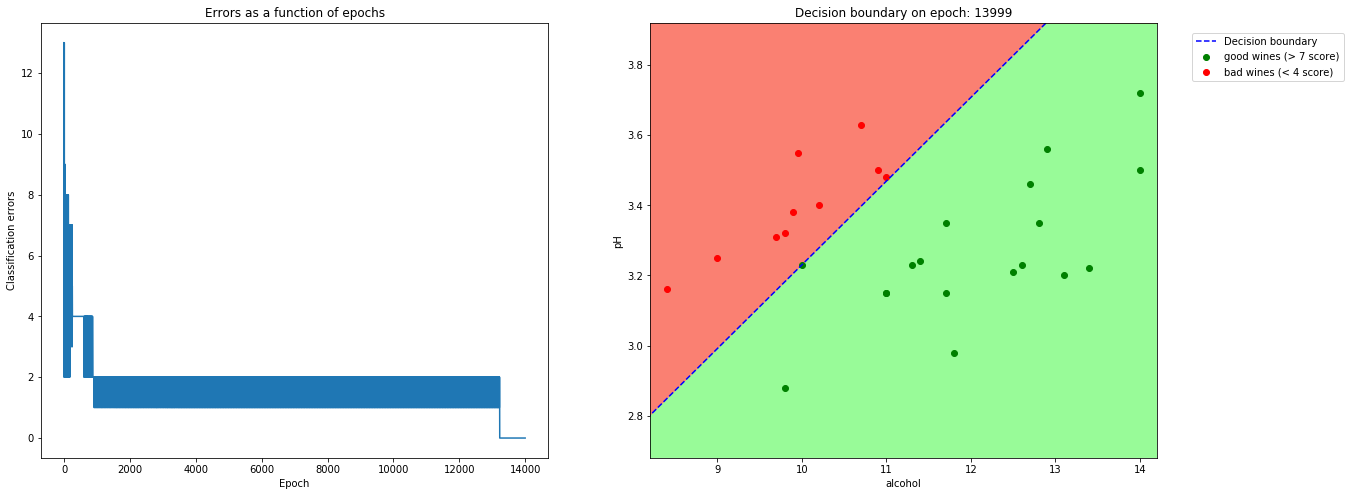

In [10]:
fig = plot_performance(train_process, selected_data, 7, 4, -1, False)
plt.show(fig)

**d)** Feature Scaling

In [11]:
def normalize_data(series):
    return (series - series.mean()) / (series.max() - series.min())

selected_wine_data_norm = copy.deepcopy(selected_data)
selected_wine_data_norm['pH'] = normalize_data(selected_wine_data_norm['pH'])
selected_wine_data_norm['alcohol'] = normalize_data(selected_wine_data_norm['alcohol'])

X = selected_wine_data_norm.loc[:, ['pH', 'alcohol']]
Y = selected_wine_data_norm['goodness'].values

In [12]:
p = Perceptron(lr=0.1)
train_norm_process = p.train(X.values, Y, 40)

Epoch 0, 6 errors
Epoch 1, 6 errors
Epoch 2, 4 errors
Epoch 3, 4 errors
Epoch 4, 2 errors
Epoch 5, 2 errors
Epoch 6, 2 errors
Epoch 7, 2 errors
Epoch 8, 2 errors
Epoch 9, 2 errors
Epoch 10, 2 errors
Epoch 11, 2 errors
Epoch 12, 2 errors
Epoch 13, 2 errors
Epoch 14, 2 errors
Epoch 15, 2 errors
Epoch 16, 2 errors
Epoch 17, 2 errors
Epoch 18, 2 errors
Epoch 19, 2 errors
Epoch 20, 4 errors
Epoch 21, 2 errors
Epoch 22, 2 errors
Epoch 23, 2 errors
Epoch 24, 2 errors
Epoch 25, 2 errors
Epoch 26, 1 errors
Epoch 27, 3 errors
Epoch 28, 3 errors
Epoch 29, 2 errors
Epoch 30, 0 errors
Epoch 31, 0 errors
Epoch 32, 0 errors
Epoch 33, 0 errors
Epoch 34, 0 errors
Epoch 35, 0 errors
Epoch 36, 0 errors
Epoch 37, 0 errors
Epoch 38, 0 errors
Epoch 39, 0 errors


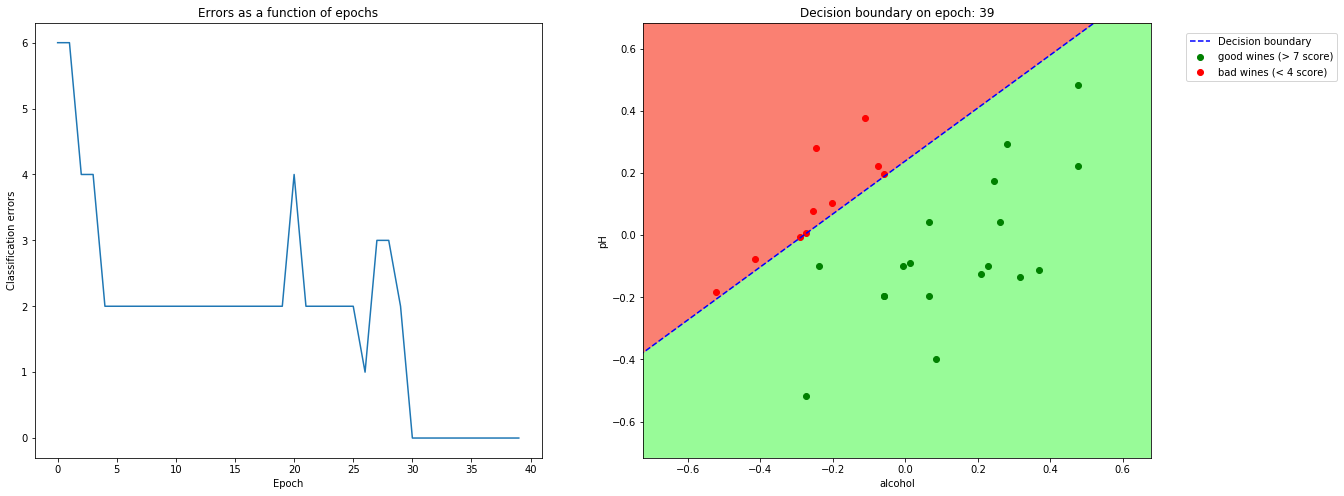

In [14]:
fig = plot_performance(train_norm_process, selected_wine_data_norm, 7, 4, -1, False)
plt.show(fig)

# V.3 My fair ADALINE

**a)** Marvin notices and chides you for torturing your perceptron. Why?

When it comes to solving harder classification tasks, we can't use our peceptron. Single layer 
perceptrons are only capable of learning linearly separable patterns so they can't
distinguishe between wines with a score of 4 and lower, and wines with a score of 7 and higher.

The Perceptron is one of the oldest and simplest learning algorithms out there,
but Adaline is an improvement over the Perceptron. While they both can learn iteratively, 
sample by sample, the Perceptron learns naturally, while Adaline via stochastic gradient descent.

*What is Gradient Descent?*
> A gradient measures how much the output of a function changes if 
> you change the inputs a little bit.

**Main differences:**
* the Perceptron uses the class labels to learn model coefficients
* Adaline uses continuous predicted values (from the net input) to learn the model coefficients, 
which is more “powerful” since it tells us by “how much” we were right or wrong

![img_3](https://github.com/rasbt/python-machine-learning-book/raw/master/faq/diff-perceptron-adaline-neuralnet/4.png)

**b)** Implement an ADALINE that:
* Has randomly initialized weights and bias
* Uses a linear activation funcion and quantizer
* Uses the Widrow-Hoff learning rule

In [ ]:
selected_data_2 = wine_data[(wine_data[quality] <= 4) | (wine_data[quality] >= 7)][['ph', 'alcohol', 'quality' 'goodness']]
selected_data_2 = selected_data_2.reset_index(drop=True)



In [ ]:
class Adaline:
    def __init(self, lr):
        self.W = random.random()
        self.lr = lr
        self.performance = list()
        
    def step(self, X):
        if (x > 0):
            return 1
        else:
            return -1;
        
    def is_accurate()
    def train():
        
    